# ベイズ最適化を用いたサンプル取得

1. 目的変数(水溶解度)の下10% quantileの中から10点をサンプルして初期とする。
1. 残った1118点の中から次にサンプルすべき点を取り出す。

In [1]:
import numpy as np 
import pandas as pd 
from rdkit import Chem 
from rdkit.Chem.Descriptors import descList
from sklearn.feature_selection import VarianceThreshold
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline 
import sklearn.gaussian_process as gp
from scipy.stats import norm 
from scipy.optimize import minimize 

from sklearn.gaussian_process import kernels
from sklearn.gaussian_process.kernels import ConstantKernel as C

from pprint import pprint

import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.rcParams['font.size'] = 25.
mpl.rcParams['figure.figsize'] = [12., 8.]

from warnings import filterwarnings
filterwarnings('ignore')

RDKit WARNING: [17:41:12] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
df = pd.read_csv('../data/delaney-solubility/delaney-processed.csv')
df['mol'] = df['smiles'].apply(Chem.MolFromSmiles)
TARGET=['measured log solubility in mols per litre']
q10 = df[TARGET].quantile(q=0.1)

In [3]:
X = np.array([list(map(lambda f: f[1](m), descList))for m in df['mol']])
print(X.shape)

(1128, 200)


In [4]:
np.random.seed(42)
index_initial = df.loc[(df[TARGET]<=q10).values[:,0],:].sample(10).index.tolist()
index_test = [num for num in np.arange(X.shape[0]) if num not in index_initial]
y_initial = df[TARGET].iloc[index_initial,:]

In [5]:
vt = VarianceThreshold()
Xsc_initial = vt.fit_transform(X[index_initial, :])
Xsc_all = vt.transform(X)
Xsc_test = vt.transform(X[index_test, :])
y_test = df[TARGET].iloc[index_test, :]

In [6]:
def probability_improvement(x_new, gaussian_process, evaluated_loss,
                         greater_is_better=False):
    assert type(evaluated_loss)is np.ndarray, "evaluated_loss must be np.array"
    if len(x_new.shape)==1:
        x_new = x_new.reshape(1, -1)
    mu, sigma = gaussian_process.predict(x_new, return_std=True)

    if greater_is_better:
        loss_optimum = np.max(evaluated_loss)
    else:
        loss_optimum = np.min(evaluated_loss)

    scaling_factor = (-1) ** (greater_is_better) 
    with np.errstate(divide='ignore'):
        Z = loss_optimum / sigma
        proba_improvement = norm.cdf(scaling_factor*Z) 
        proba_improvement[sigma == 0.0] == 0.0
    if len(proba_improvement.shape)==1:
        proba_improvement = proba_improvement.reshape(-1, 1)
    return proba_improvement

In [7]:
def expected_improvement(x_new, gaussian_process, evaluated_loss,
                         greater_is_better=False):
    assert type(evaluated_loss)is np.ndarray, "evaluated_loss must be np.array"
    if len(x_new.shape)==1:
        x_new = x_new.reshape(1, -1)
    mu, sigma = gaussian_process.predict(x_new, return_std=True)
    mu = mu.reshape(-1,)
    if greater_is_better:
        loss_optimum = np.max(evaluated_loss)
    else:
        loss_optimum = np.min(evaluated_loss)

    scaling_factor = (-1) ** (not greater_is_better)
    # In case sigma equals zero
    with np.errstate(divide='ignore'):
        Z = scaling_factor * (mu - loss_optimum) / sigma
        ei = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] == 0.0
    return ei

In [8]:
def confidence_bound(x_new, gaussian_process, evaluated_loss,
                         greater_is_better=False):
    """LCB (default) / UCB for maximization"""
    assert type(evaluated_loss)is np.ndarray, "evaluated_loss must be np.array"
    if len(x_new.shape)==1:
        x_new = x_new.reshape(1, -1)
    mu, sigma = gaussian_process.predict(x_new, return_std=True)
    n_samples = evaluated_loss.shape[0]
    with np.errstate(divide='ignore'):
        kappa = np.sqrt(np.log( n_samples )/n_samples)
        if greater_is_better:
            # upper confindence bound
            cb = mu + kappa * sigma
        else:
            # lower confindence bound
            cb = mu - kappa * sigma
    return cb 

In [9]:
def plot_samples(x_obs,y_obs,x_test, gpr):
    """
    Plot for sampled and estimated response
    """
    y_m, y_s = gpr.predict(x_test, return_std=True)
    y_m = y_m.reshape(-1,) 
    if len(y_obs.shape)==2:
        y_obs = y_obs.copy().reshape(-1,)
    n_samples = x_obs.shape[0] + x_test.shape[0]
    n_trains = x_obs.shape[0]
    plt.plot(range(n_trains), y_obs, 'o')
    plt.plot(range(n_trains, n_samples), y_m)
    plt.fill_between(range(n_trains, n_samples), y_m-y_s,y_m+y_s,
                    alpha=.3, color='b')
    plt.xlim( [0, n_samples] )
    plt.ylim(np.array([-1,1])* 15)
    plt.xlabel('sample index'); plt.ylabel('$y$')


In [10]:
k1 = kernels.Sum(C()*kernels.RBF(), C()*kernels.RationalQuadratic())
k2 = kernels.Sum(C()*kernels.Matern(), C()*kernels.ExpSineSquared())
k3 = kernels.Sum(C()*kernels.DotProduct(), kernels.ConstantKernel())
ks = kernels.Sum(k1, k2)
ks = kernels.Sum(ks, k3)
sum_kernel = kernels.Sum(ks, kernels.WhiteKernel())

## Expected Improvementを使って改善の様子を確認

In [11]:
Xtrain = Xsc_all[index_initial,:].copy()# deepcopy just in case 
ytrain = df[TARGET].iloc[index_initial,:].values.copy()
Xtest = Xsc_all[index_test,:].copy()
ytest = df[TARGET].iloc[index_test,:].values.copy()
print(ytrain.shape, ytest.shape)

gpr = make_pipeline(StandardScaler(), 
                        gp.GaussianProcessRegressor(kernel=sum_kernel, normalize_y=True))

(10, 1) (1118, 1)


In [12]:
n_samples = Xsc_all.shape[0]
print(type(index_initial), type(index_test))# データ型の確認

<class 'list'> <class 'list'>


# of train 11 # of test 1117


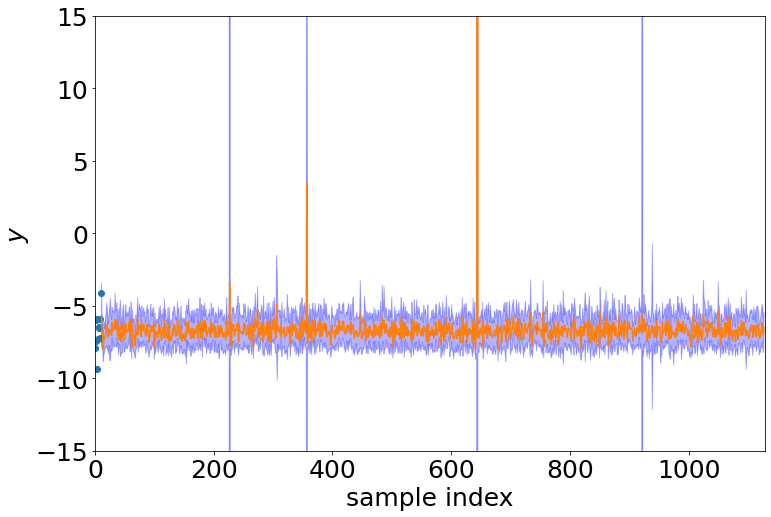

# of train 12 # of test 1116


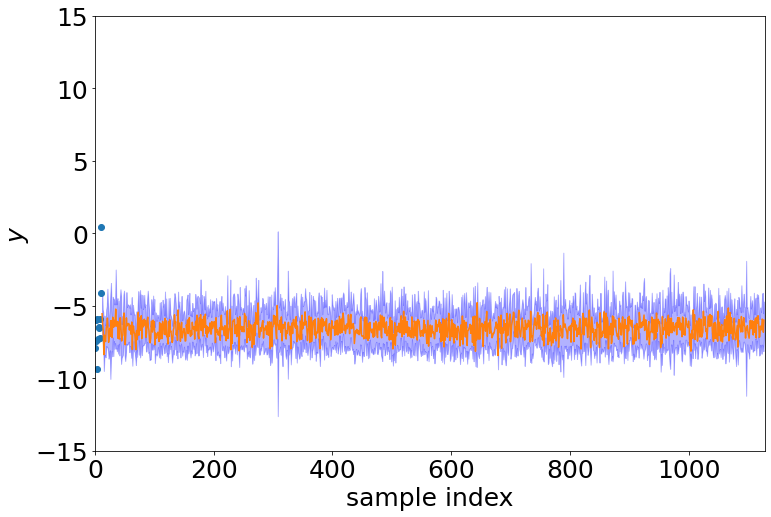

# of train 13 # of test 1115


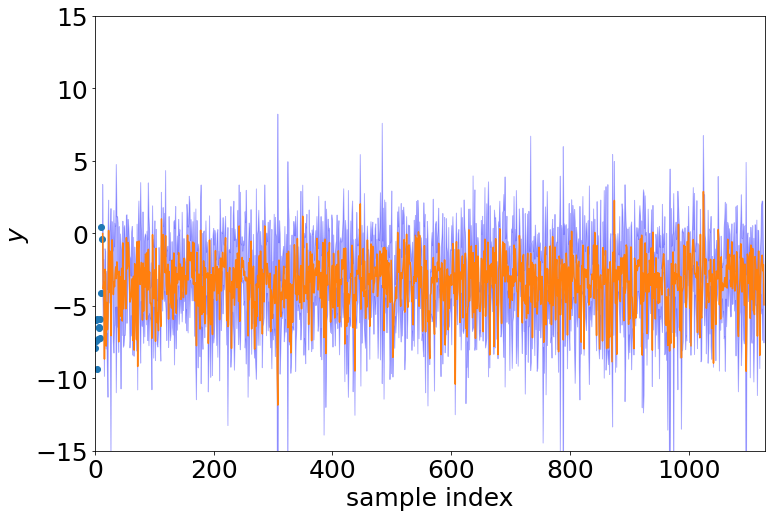

# of train 14 # of test 1114


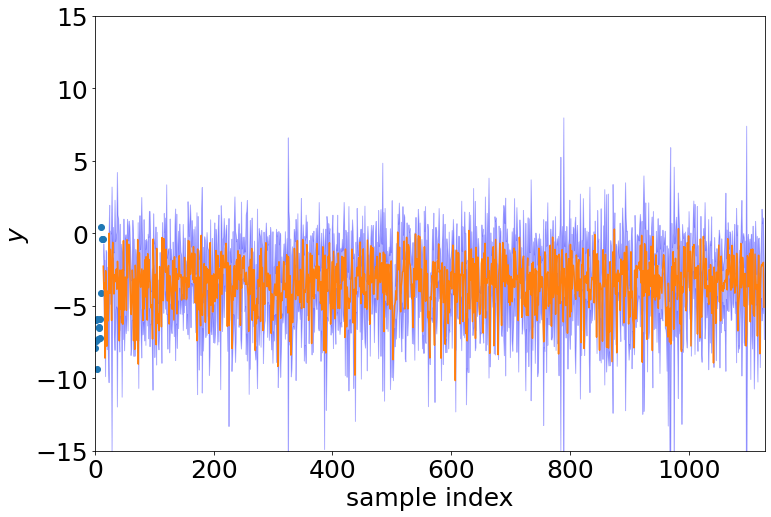

# of train 15 # of test 1113


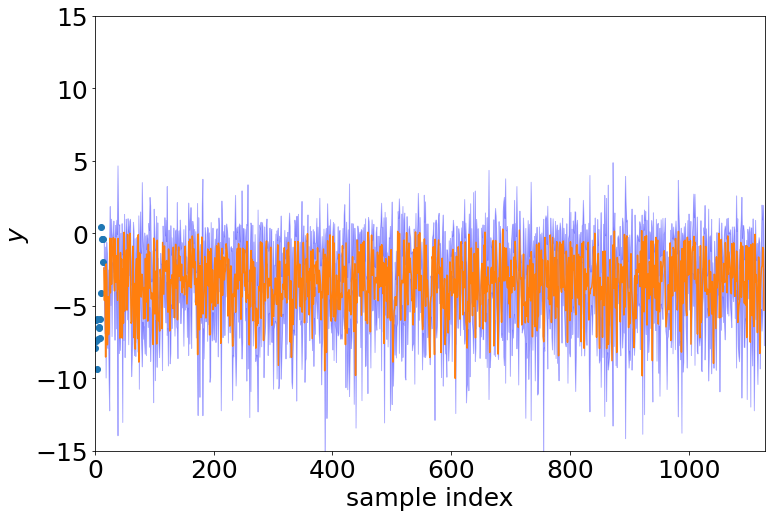

# of train 16 # of test 1112


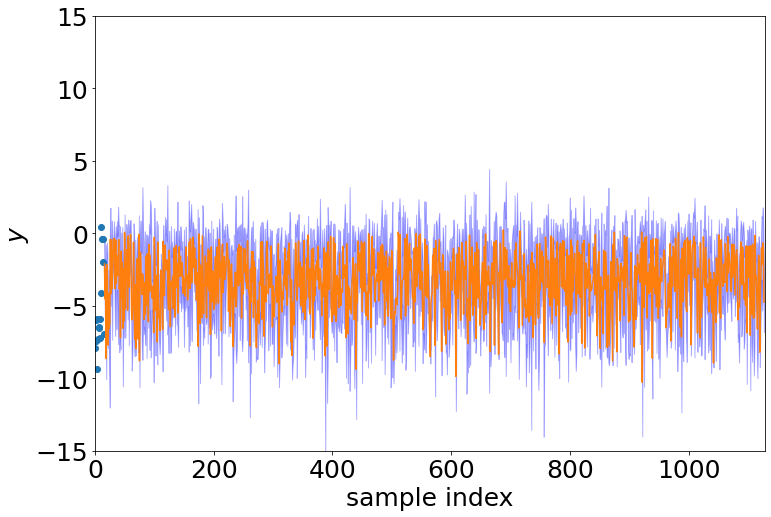

# of train 17 # of test 1111


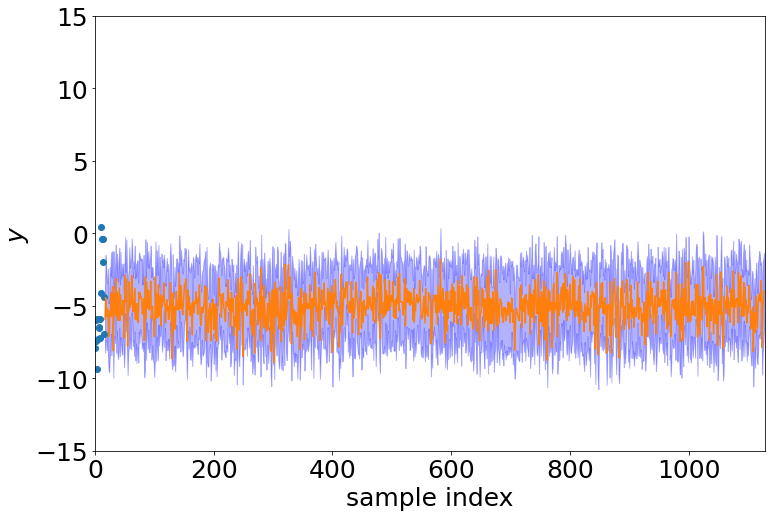

# of train 18 # of test 1110


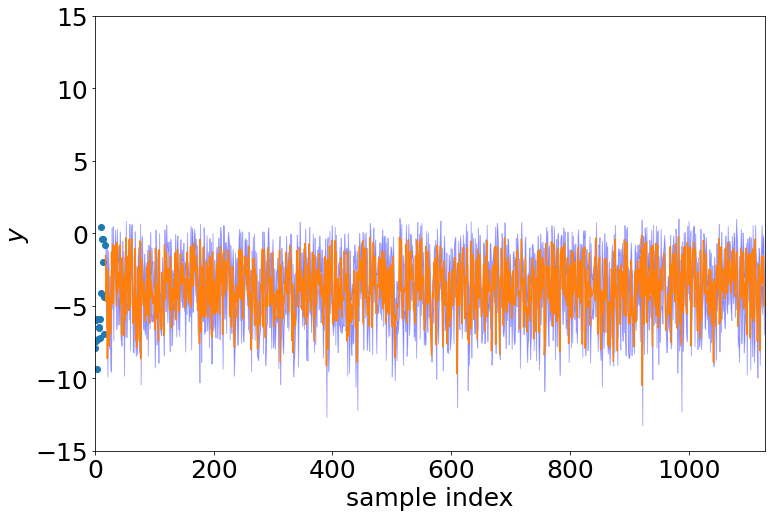

# of train 19 # of test 1109


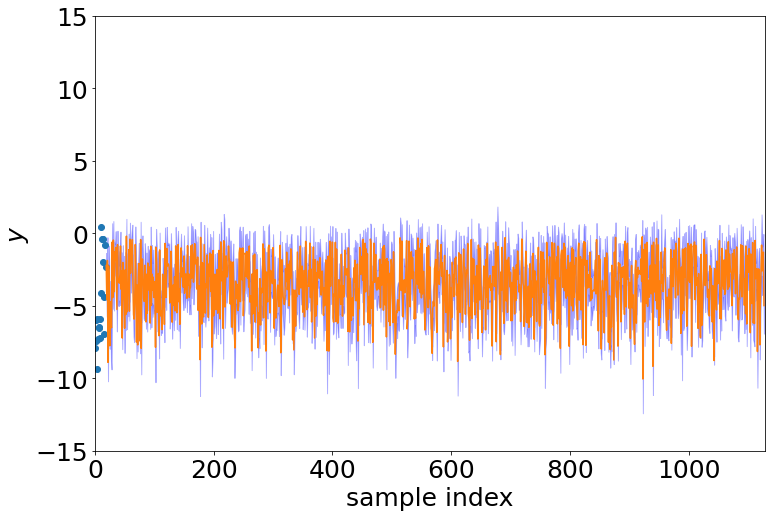

# of train 20 # of test 1108


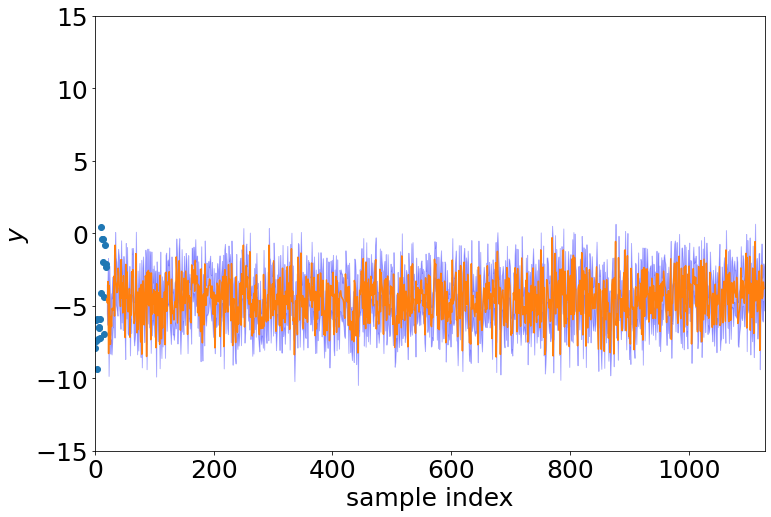

In [13]:
n_iters = 10 # number of samples
for i_iter in range(n_iters):
    gpr.fit(Xtrain, ytrain)
    EI = [expected_improvement(Xsc_all[idx,:], gpr,
                           ytrain, greater_is_better=True).reshape(-1,)
        for idx in index_test]
    
    subindex_max = np.array(EI).argmax()
    Xtrain = np.r_[Xtrain, Xtest[subindex_max,:].reshape(1,-1)]
    ytrain = np.r_[ytrain, ytest[subindex_max].reshape(-1,1)]
    

    index_initial.append(index_test.pop(subindex_max))
    print('# of train', len(index_initial), '# of test', len(index_test))
    Xtest = Xsc_all[index_test,:]
    plot_samples(Xtrain, ytrain, Xsc_all[index_test,:], gpr)
    plt.savefig('../results/bo/sample_result{}.jpg'.format(i_iter+1))
    plt.show()

## 獲得関数の違いを確認

In [14]:
score_log = dict()
np.random.seed(42)
index_initial = df.loc[(df[TARGET]<=q10).values[:,0],:].sample(10).index.tolist()
y_initial = df[TARGET].iloc[index_initial,:]

for f in [probability_improvement, expected_improvement, confidence_bound]:
    Xtrain = Xsc_all[index_initial, :].copy()
    ytrain = df[TARGET].iloc[index_initial, :].values.copy()
    index_train = index_initial.copy()
    index_test = [num for num in np.arange(X.shape[0]) if num not in index_initial]
    n_iters = 10
    print(f.__name__)
    for i_iter in range(n_iters):
        gpr.fit(Xtrain, ytrain)
        scores = [f(Xsc_all[idx,:], gpr,
                               ytrain, greater_is_better=True).reshape(-1,)
            for idx in index_test]
        
        subindex_max = np.array(scores).argmax()
        Xtrain = np.r_[Xtrain, Xtest[subindex_max,:].reshape(1,-1)]
        ytrain = np.r_[ytrain, ytest[subindex_max].reshape(-1,1)]
        try:
            score_log[f.__name__].append(ytrain.max())
        except KeyError:
            score_log[f.__name__] = [ytrain.max()]

        index_train.append(index_test.pop(subindex_max))
        print('# of train', len(index_train), '# of test', len(index_test))
        Xtest = Xsc_all[index_test,:]
score_log

probability_improvement
# of train 11 # of test 1117
# of train 12 # of test 1116
# of train 13 # of test 1115
# of train 14 # of test 1114
# of train 15 # of test 1113
# of train 16 # of test 1112
# of train 17 # of test 1111
# of train 18 # of test 1110
# of train 19 # of test 1109
# of train 20 # of test 1108
expected_improvement
# of train 11 # of test 1117
# of train 12 # of test 1116
# of train 13 # of test 1115
# of train 14 # of test 1114
# of train 15 # of test 1113
# of train 16 # of test 1112
# of train 17 # of test 1111
# of train 18 # of test 1110
# of train 19 # of test 1109
# of train 20 # of test 1108
confidence_bound
# of train 11 # of test 1117
# of train 12 # of test 1116
# of train 13 # of test 1115
# of train 14 # of test 1114
# of train 15 # of test 1113
# of train 16 # of test 1112
# of train 17 # of test 1111
# of train 18 # of test 1110
# of train 19 # of test 1109
# of train 20 # of test 1108


{'probability_improvement': [-5.886,
  -5.03,
  -5.03,
  -5.03,
  -2.77,
  -2.77,
  -2.77,
  -1.661,
  -1.661,
  -1.661],
 'expected_improvement': [-4.081,
  -1.99,
  0.43,
  0.43,
  0.43,
  0.43,
  0.43,
  0.43,
  0.43,
  0.43],
 'confidence_bound': [-4.081,
  -1.99,
  0.43,
  0.43,
  0.43,
  0.43,
  0.43,
  0.43,
  0.43,
  0.43]}

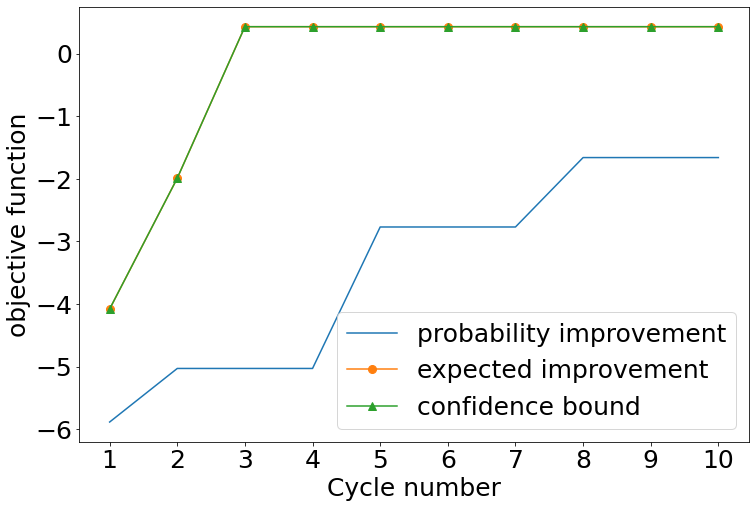

In [15]:
mpl.rcParams['lines.markersize'] = 8
for points, marker in zip(score_log.values(), ['-', '-o', '-^']):
    plt.plot(points, marker)
plt.xticks(range(len(points)), np.arange(1, len(points)+1))
plt.xlabel('Cycle number')
plt.ylabel('objective function'); 
plt.legend(list(map(lambda s:s.replace('_',' '), score_log.keys())))
plt.savefig('../results/bo/trace.jpg')